[Source](https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb)

In [1]:
%cd ./input

C:\Users\livio\OneDrive\Desktop\time_series_forecasting_with_dnn\input


In [2]:
import random
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers

In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [4]:
dataset = pd.read_csv('Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


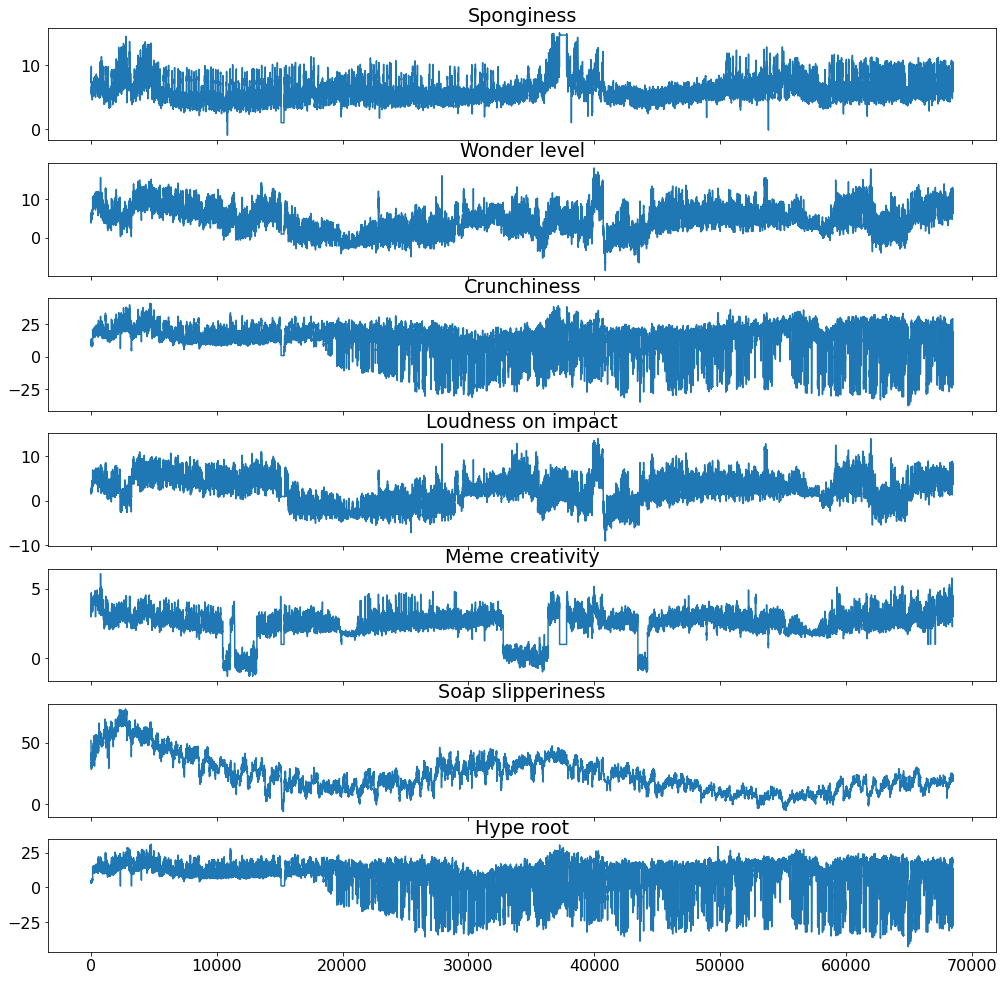

In [5]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

(68528, 7)


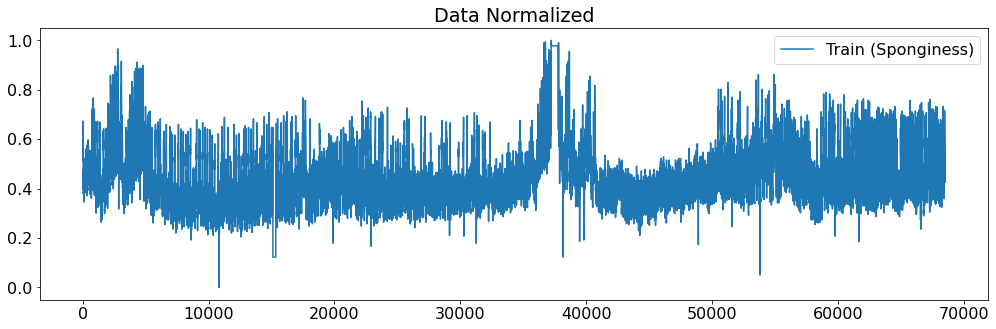

In [6]:
X_train_raw = dataset.copy()
print(X_train_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (Sponginess)')
plt.title('Data Normalized')
plt.legend()
plt.show()

In [7]:
#how many samples from the training data I take for each training step
window = 400
#how many samples I skip when I move the window
stride = 10
#how many samples in the future my model predicts
telescope = 20

In [9]:
def build_sequences(df, target_labels, window, stride, telescope):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    #copy because this way temp_df is decoupled from df
    #values converts from a dataframe to a numpy array
    temp_df = df.copy().values
    #target labels => what I want to predict??-- for each step what I predict in the future
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length at the BEGINNING of the data
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0
    #extract from the time series segments of size window and specified stride and then concatenate
    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [10]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [11]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [12]:
target_labels = dataset.columns

In [13]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape

((6838, 400, 7), (6838, 20, 7))

In [14]:
n_hidden = 100

In [15]:
input_train = tfkl.Input(shape=(X_train.shape[1], X_train.shape[2]))
output_train = tfkl.Input(shape=(y_train.shape[1], y_train.shape[2]))
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 400, 7), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 7), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [16]:
encoder_stack_h, encoder_last_h, encoder_last_c = tfkl.LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 400, 100), dtype=tf.float32, name=None), name='lstm/transpose_1:0', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:4', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:5', description="created by layer 'lstm'")


In [17]:
encoder_last_h = tfkl.BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = tfkl.BatchNormalization(momentum=0.6)(encoder_last_c)

In [18]:
decoder_input = tfkl.RepeatVector(output_train.shape[1])(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='repeat_vector/Tile:0', description="created by layer 'repeat_vector'")


In [19]:
decoder_stack_h = tfkl.LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
 return_state=False, return_sequences=True)(
 decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='lstm_1/transpose_1:0', description="created by layer 'lstm_1'")


In [20]:
attention = tfkl.dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = tfkl.Activation('softmax')(attention)
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 400), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")


In [21]:
context = tfkl.dot([attention, encoder_stack_h], axes=[2,1])
context = tfkl.BatchNormalization(momentum=0.6)(context)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='batch_normalization_2/batchnorm/add_1:0', description="created by layer 'batch_normalization_2'")


In [22]:
decoder_combined_context = tfkl.concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 200), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [23]:
out = tfkl.TimeDistributed(tfkl.Dense(output_train.shape[2]))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 7), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")


In [24]:
model = tfk.Model(inputs=input_train, outputs=out)
opt = tfk.optimizers.Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 7)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 400, 100),   43200       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 batch_normalization (BatchNorm  (None, 100)         400         ['lstm[0][1]']                   
 alization)                                                                                   

In [25]:
batch_size = 32
epochs = 200

In [26]:
history = model.fit(
                    x = X_train,
                    y = y_train,
                    batch_size = batch_size,
                    epochs = epochs, 
                    verbose=1,
                    validation_split=0.2,
                    callbacks = [
                        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
                        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
                    ]).history

Epoch 1/200
171/171 [==============================] - 131s 723ms/step - loss: 0.0380 - mae: 0.0994 - val_loss: 0.0099 - val_mae: 0.0703 - lr: 0.0100
Epoch 2/200
171/171 [==============================] - 107s 623ms/step - loss: 0.0081 - mae: 0.0670 - val_loss: 0.0091 - val_mae: 0.0647 - lr: 0.0100
Epoch 3/200
171/171 [==============================] - 102s 594ms/step - loss: 0.0080 - mae: 0.0666 - val_loss: 0.0089 - val_mae: 0.0667 - lr: 0.0100
Epoch 4/200
171/171 [==============================] - 102s 598ms/step - loss: 0.0074 - mae: 0.0644 - val_loss: 0.0082 - val_mae: 0.0614 - lr: 0.0100
Epoch 5/200
171/171 [==============================] - 107s 627ms/step - loss: 0.0071 - mae: 0.0630 - val_loss: 0.0083 - val_mae: 0.0669 - lr: 0.0100
Epoch 6/200
171/171 [==============================] - 108s 632ms/step - loss: 0.0068 - mae: 0.0616 - val_loss: 0.0082 - val_mae: 0.0644 - lr: 0.0100
Epoch 7/200
171/171 [==============================] - 106s 619ms/step - loss: 0.0067 - mae: 0.0611 

In [31]:
#%cd ../model/

# Save the best model
#model.save('seq2seq')

# To avoid filling the memory
#del model

### Prediction of the next 864 time steps

In [32]:
#the samples I want to predict in the future using auto regression
reg_telescope = 864

In [33]:
#covert dataset to tensor to mimic evaluator(codalab) input
X = tf.constant(dataset, dtype = tf.float32, shape=[68528,7])

In [34]:
X = X.numpy()
X_min = X.min(axis=0)
X_max = X.max(axis=0)

In [35]:
#future is the samples I use to predict the next steps 
future = X[-window:]
future.shape

(400, 7)

In [36]:
#normalize
future = (future-X_min)/(X_max-X_min)
#add axis
future = np.expand_dims(future, axis=0)
print(future.shape)
type(future)

(1, 400, 7)


numpy.ndarray

In [37]:
# Auto regressive forecasting
reg_predictions = np.array([])
X_temp = future
for reg in range(0,reg_telescope + telescope,telescope): 
    pred_temp = model.predict(X_temp)
    #the first prediction
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

reg_predictions = reg_predictions[:,:reg_telescope,:]

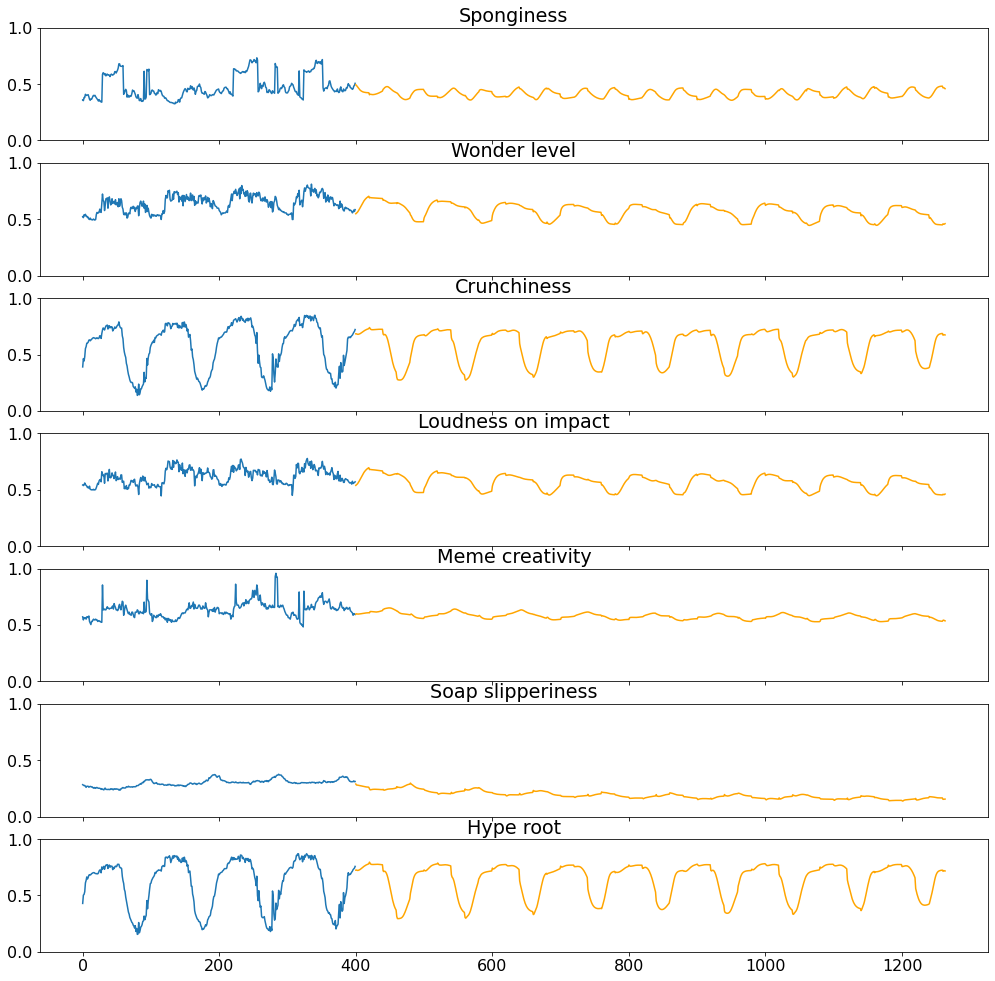

In [38]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), reg_predictions[0,:,i], color='orange')
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()

In [39]:
#denormalize
reg_predictions = reg_predictions * (X_max - X_min) + X_min
future = future * (X_max - X_min) + X_min

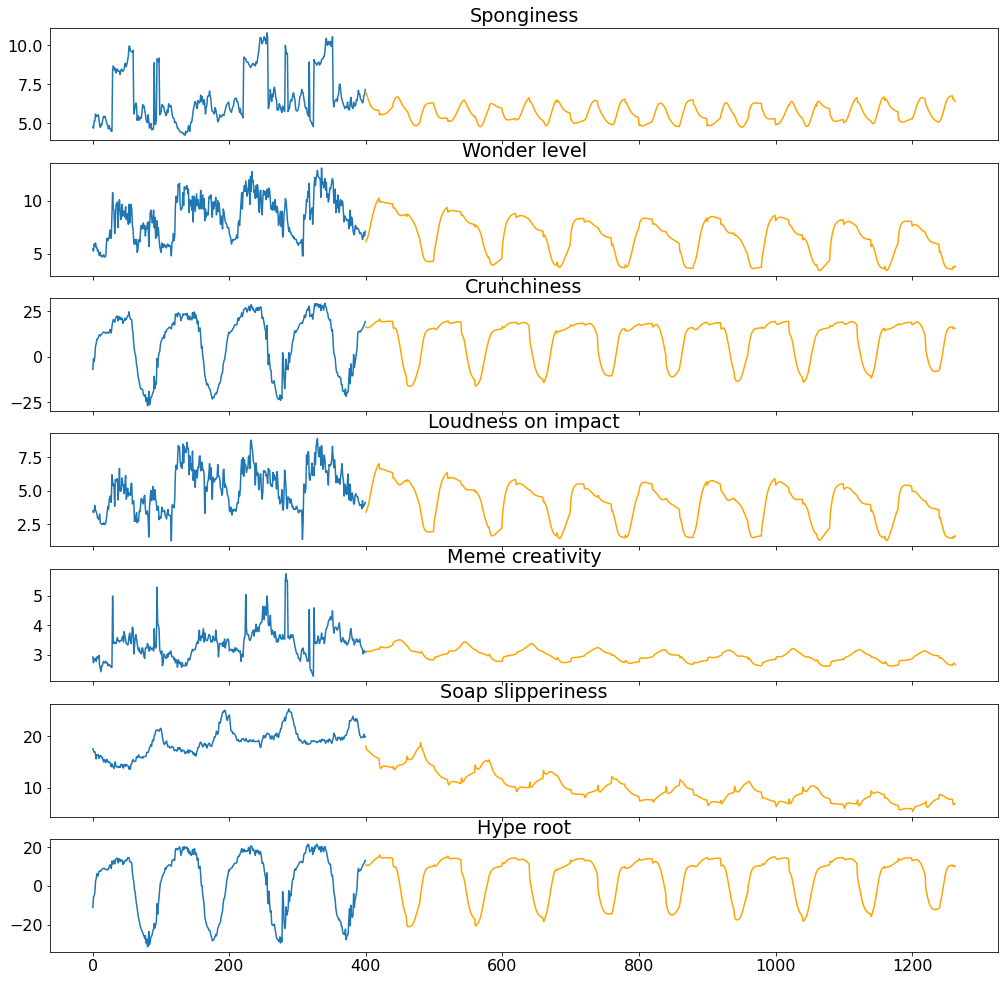

In [40]:
#plot the result
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), reg_predictions[0,:,i], color='orange')
    axs[i].set_title(col)
plt.show()